
### Business problem 
The business seeks to understand public sentiment regarding Apple and Google products based on social media discussions. Analyzing sentiment on platforms like Twitter can provide actionable insights into customer preferences, satisfaction, and concerns. To address this, an NLP model must be developed to automatically classify the sentiment (positive, negative, or neutral) in Tweets mentioning these products. The model aims to streamline sentiment analysis, reducing manual effort, and enabling timely responses to market trends and customer feedback, ultimately improving product marketing and customer engagement strategies.

### Objectives 
1. To develop a model to classify tweets as positive, negative, or neutral regardingg Apple and Google products.
2. To optimize the model to achieve high accuracy and precision in sentiment predictions.
3. To ensure the model can be adapted for sentiment analysis of other brands or products in the future.

### Key stakeholders
1. Data Scientists
2. Product Managers
3. Marketing teams
4. Executive and Decision Makers

### Data understanding
The data being used in this project consists of over 9,000 Tweets about Apple and Google products, which have been labeled by human raters as positive, negative, or neutral. This dataset is well-suited for the business problem because it reflects real user opinions and interactions on social media, providing valuable insight into how customers feel about these products. The labeled sentiment in each tweet offers a solid foundation for building and training a model to automatically classify sentiment, aligning with the goal of improving sentiment analysis automation.

The context for implementing the solution involves leveraging sentiment analysis to gain insights into public perception of Apple and Google products through Twitter data. The model will analyze tweets rated as positive, negative, or neutral, providing stakeholders with valuable information on consumer attitudes. This can inform marketing strategies, product improvements, and customer engagement initiatives, helping the companies understand their brand reputation and customer satisfaction levels. The insights derived from the model will aid in decision-making processes and strategic planning.


In [64]:
#libraries and packages to use

import pandas as pd
import re
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt', quiet=True)
np.random.seed(0)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

#download nltk resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [65]:
#load the data
sentiments = pd.read_csv("Data/tweet_product_company.csv", encoding='ISO-8859-1')


#rename column names 
# Define new column names
new_column_names = {
    'tweet_text': 'tweet_content',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion_result'
}

# Rename columns
sentiments.rename(columns=new_column_names, inplace=True)

# Display the updated DataFrame
sentiments.head(20)

,tweet_content,product,Emotion_result
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [66]:
sentiments.describe()

,tweet_content,product,Emotion_result
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [67]:

# Calculate percentage of missing values
missing_percentage = sentiments.isna().sum() / len(sentiments) * 100
missing_percentage

tweet_content      0.010997
product           63.807324
Emotion_result     0.000000
dtype: float64

In [68]:
sentiments["product"].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [69]:
sentiments["product"].mode()

0    iPad
dtype: object

In [70]:
# I want to impute the missing values in the product columns using the tweet comments key words

# Loop through each row to check the content and impute missing product values
for index, row in sentiments.iterrows():
    tweet_content = row['tweet_content']
    if pd.isnull(row['product']):
        if isinstance(tweet_content, str):
            if 'itunes' in tweet_content.lower() or 'ipad' in tweet_content.lower() or 'iphone' in tweet_content.lower():
                sentiments.at[index, 'product'] = 'iPad or iPhone App'
            elif 'google' in tweet_content.lower() or 'android' in tweet_content.lower():
                sentiments.at[index, 'product'] = 'Android'
            else:
                sentiments.at[index, 'product'] = 'Other Product'


In [71]:
# Calculate percentage of missing values
missing_percentage = sentiments.isna().sum() 
missing_percentage

tweet_content     1
product           1
Emotion_result    0
dtype: int64

In [72]:
#delete the null row 
sentiments = sentiments.dropna(subset=['tweet_content', 'product'])
# Calculate percentage of missing values
missing_percentage = sentiments.isna().sum() 
missing_percentage


tweet_content     0
product           0
Emotion_result    0
dtype: int64

## Data preparation

why did you choose the data preparation steps that you did, and what was the result?
such as feature engineering, using pipelines, or using unsupervised techniques
Goes above and beyond with data preparation, such as feature engineering, using pipelines, or using unsupervised techniques

Supervised learning is the core of this project, but feel free to use unsupervised techniques for data analysis or preparation

Data Preprocessing
1. Tokenize the text (split into words/sentences).
2. Convert to lowercase, remove numbers, handle contractions.
3. Stemming/lemmatization to reduce words to their base forms.
4. Handle stop words and rare words.

Feature Engineering

Use techniques like TF-IDF, Bag-of-Words, Word2Vec, or FastText for converting text into numerical features.

Consider word embeddings or transformers if working with more complex NLP tasks.

Preprocessing: NLTK

In [73]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, use_stemming=False):
        self.use_stemming = use_stemming
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer() if use_stemming else None
        self.lemmatizer = WordNetLemmatizer() if not use_stemming else None
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        words = text.split()
        words = [word for word in words if word not in self.stop_words]
        return words

    def stem_or_lem(self, words):
        if self.use_stemming:
            return [self.stemmer.stem(word) for word in words]
        else:
            return [self.lemmatizer.lemmatize(word) for word in words]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        cleaned_data = [self.clean_text(text) for text in X]
        processed_data = [' '.join(self.stem_or_lem(words)) for words in cleaned_data]
        return processed_data

# Create the pipeline
text_pipeline = Pipeline([
    ('preprocessor', TextPreprocessor(use_stemming=False)),
    ('vectorizer', CountVectorizer())
])

# Example of applying the pipeline on a dataset
data = ['I have an iPhone and I love it!', 'Google is the best for Android.']
transformed_data = text_pipeline.fit_transform(data)

# Retrieve and print the feature names
vocab = text_pipeline.named_steps['vectorizer'].get_feature_names_out()
print("Feature Names:", vocab)

# Output the transformed data
print(transformed_data)

Feature Names: ['android' 'best' 'google' 'iphone' 'love']
  (0, 3)	1
  (0, 4)	1
  (1, 2)	1
  (1, 1)	1
  (1, 0)	1


In [81]:
# Get feature names from the vectorizer
feature_names = text_pipeline.named_steps['vectorizer'].get_feature_names_out()
dense = transformed_data.todense()
transformed_df = pd.DataFrame(dense, columns=feature_names)

# Add the original dataset's tweet content to the DataFrame
transformed_df['original_tweet'] = sentiments['tweet_content'].reset_index(drop=True)

# Reorder the columns to see the original text first
transformed_df = transformed_df[['original_tweet'] + list(feature_names)]

# Display the transformed DataFrame
transformed_df.head()


,original_tweet,android,best,google,iphone,love
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0,0,0,1,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1,1,1,0,0


Word Frequency Analysis:
love       1
iphone     1
google     1
best       1
android    1
dtype: int64


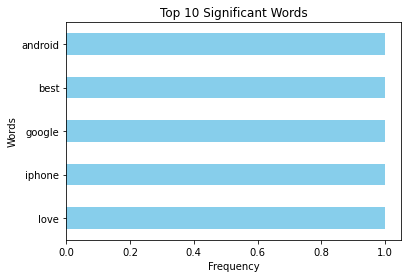

In [74]:


# transformed_data` is the output from the pipeline
# `feature_names` contains the names of the features
feature_names = text_pipeline.named_steps['vectorizer'].get_feature_names_out()
dense = transformed_data.todense()
df = pd.DataFrame(dense, columns=feature_names)

# Get the sum of each feature (word frequency)
word_counts = df.sum().sort_values(ascending=False)

# Display the most significant words
print("Word Frequency Analysis:")
print(word_counts)

# Optional: Visualize the most significant words
import matplotlib.pyplot as plt

word_counts.head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Significant Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


## Modeling
what modeling package(s) did you use, which model(s) within the package(s), and what tuning steps did you take?
Goes above and beyond in the modeling process, such as using models from multiple different packages and different model explainability tools

 Model Selection

Choose a machine learning model (e.g., Naive Bayes, SVM, Logistic Regression) or a deep learning model (e.g., LSTM, BERT).

For more advanced tasks, explore transformers with pre-trained models like BERT, GPT.

6. Model Training

Split data into training and test sets.

Train the model on the training data.
Modeling: Scikit-learn, TensorFlow, PyTorch.

In [83]:

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# use original DataFrame with 'tweet_content' and 'Emotion_result' columns

# Split the dataset into features and target variable
X = sentiments['tweet_content']  # Feature
y = sentiments['Emotion_result']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with text preprocessing and logistic regression
text_pipeline = Pipeline([
    ('preprocessor', TextPreprocessor(use_stemming=False)),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression model
])

# Fit the model
text_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = text_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6679494227597581

Classification Report:
                                     precision    recall  f1-score   support

                      I can't tell       0.10      0.04      0.05        27
                  Negative emotion       0.55      0.24      0.33       121
No emotion toward brand or product       0.71      0.80      0.75      1065
                  Positive emotion       0.60      0.54      0.57       606

                          accuracy                           0.67      1819
                         macro avg       0.49      0.41      0.43      1819
                      weighted avg       0.65      0.67      0.65      1819



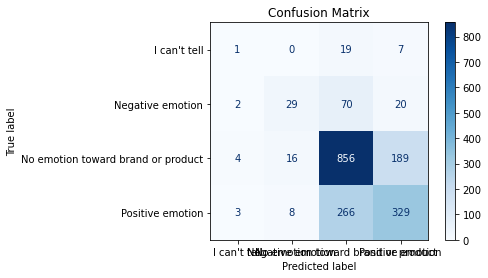

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=text_pipeline.classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=text_pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## Evaluation

how well did your final model perform?

Evaluate performance using metrics like accuracy, F1-score, precision, recall for classification tasks, or BLEU score for translation.
Use a confusion matrix for classification tasks to assess true positives, false positives, etc.

8. Tuning and Optimization
Perform hyperparameter tuning using grid search or random search.
Test different architectures for neural networks if applicable.

9. Deployment
Convert the model into a format ready for deployment, such as using APIs (Flask/Django), or directly integrating into an application.

10. Documentation and Reporting
Write thorough documentation about the project process, decisions, and model performance.

Prepare visualizations of key findings, feature importance, and model metrics.